# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [ ]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



## Given example

In [ ]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
18/18 [==============================] - 159s 2s/step - loss: 2.9631 - accuracy: 0.0546 - val_loss: 2.9464 - val_accuracy: 0.0510
Epoch 2/50
18/18 [==============================] - 5s 281ms/step - loss: 2.9453 - accuracy: 0.0552 - val_loss: 2.9436 - val_accuracy: 0.0622
Epoch 3/50
18/18 [==============================] - 5s 275ms/step - loss: 2.9429 - accuracy: 0.0593 - val_loss: 2.9397 - val_accuracy: 0.0667
Epoch 4/50
18/18 [==============================] - 5s 275ms/step - loss: 2.9368 - accuracy: 0.0673 - val_loss: 2.9327 - val_accuracy: 0.0728
Epoch 5/50
18/18 [==============================] - 5s 275ms/step - loss: 2.9310 - accuracy: 0.0722 - val_loss: 2.9280 - val_accuracy: 0.0716
Epoch 6/50
18/18 [==============================] - 5s 284ms/step - loss: 2.9224 - accuracy: 0.0787 - val_loss: 2.9182 - val_accuracy: 0.0817
Epoch 7/50
18/18 [==============================] - 5s 275ms/step - loss: 2.9148 - accuracy: 0.0832 - val_loss: 2.9120 - val_accuracy: 0.0835
Epoch 8

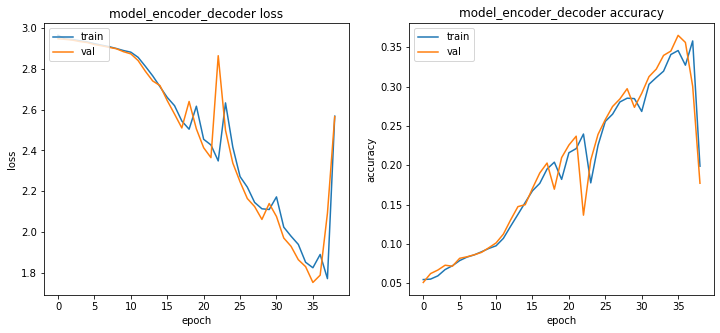

In [ ]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

## Bahdanau Attention and Luong General Attention classes

Let us implement the Bahdanau Attention and the Luong general Attention classes. The only modifications with respect the given code for the Loung dot attention are the following:
+ Initialization of some weights.
+ Change the attention score to the appropiate one in each case.

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        #Let us initialize the dense layers for the Bahdanau's attention 
        
        #weight matrices
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)

        self.v = tf.keras.layers.Dense(1)


    def call(self, query, values):
      #As the given code
      query_with_time_axis = tf.expand_dims(query,1)

      #Bahdanau score
      score = self.v(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

      #Attention_weights shape == (batch_size, max_length, 1)
      attention_weights = tf.nn.softmax(score, axis=1)
        
      #context_vector shape after sum == (batch_size, hidden_size)
      context_vector = attention_weights * values
      context_vector = tf.reduce_sum(context_vector, axis=1)
      
      return context_vector, attention_weights

In [ ]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        
        #Let us initialize the dense layers for the Bahdanau's attention 
        
        #weight matrix
        self.W = tf.keras.layers.Dense(units)
        

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        #Luong multiplicative score
        score = tf.transpose(tf.matmul(query_with_time_axis, self.W(values_transposed)), perm=[0, 2, 1])

        #attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        #context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)


        return context_vector, attention_weights

## Comparative and weight visualization

### Weight visualization functions

First of all, let us create three functions in order to visualize the attention weights. In order to do this, we will create a function that for the given encoders and decoders, we will be able to plot the attention weights. The function is similar to the build_attention_model function.

In [ ]:
def build_attention_model_plot(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
    
    #Let us create the attention_plot variable
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  #One hot encoding to the input sequence
  seq = one_hot_encode(seq_in,n_features)

  #ENCODER STEP
  #-----------
  #The same as before, but we do not have to initialize anything, all the parameters are given
  encoder_inputs = np.array(seq)
  encoder_inputs = encoder_inputs.reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float64)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

  states = [encoder_state_h, encoder_state_c]

  #DECODER STEP
  #------------
  all_outputs = []
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 
  inputs = decoder_input_data
  decoder_outputs = encoder_state_h

  #Decoder will only process one timestep at a time.
  for t in range(n_timesteps_in):
      #Pay attention!
      #decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      #Concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)

      #Store the attention weights to plot them
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()
      
      #Passing the concatenated vector to the LSTM
      #Run the decoder on one timestep and previous states
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      #Use the last hidden state for prediction the output
      #save the current prediction
      #we will concatenate all predictions later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      #Reinject the output (prediction) as inputs for the next loop iteration
      #as well as update the states
      inputs = outputs
      states = [state_h, state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  #One hot decoding
  seq_out=one_hot_decode(decoder_outputs[0])
  
  return seq_in, seq_out, attention_plot

In [ ]:
import matplotlib.ticker as ticker

def atent_plot(attention_plot, seq_in, seq_out):
  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(111)
  ax.matshow(attention_plot)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.set_xticklabels([''] + seq_in, fontdict = {'fontsize': 8})
  ax.set_yticklabels([''] + seq_out, fontdict = {'fontsize': 8})
  plt.show()


In [ ]:
def visualization(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  seq_in, seq_out, attention_plot = build_attention_model_plot(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)
  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  atent_plot(attention_plot, seq_in, seq_out)

Let us repeat the build_attention_model function but returning, besides the model, the encoder_lstm, decoder_lstm and the decoder_dense in order to use the previous functions and plot the weighted matrix.

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense

### Comparative

Let us recall the performance using Luong dot attention. Nevertheless, let us increase the number of epochs and the patience in order to improve the results.

Epoch 1/200
18/18 [==============================] - 157s 2s/step - loss: 2.9654 - accuracy: 0.0532 - val_loss: 2.9468 - val_accuracy: 0.0531
Epoch 2/200
18/18 [==============================] - 5s 282ms/step - loss: 2.9447 - accuracy: 0.0547 - val_loss: 2.9423 - val_accuracy: 0.0654
Epoch 3/200
18/18 [==============================] - 5s 281ms/step - loss: 2.9391 - accuracy: 0.0640 - val_loss: 2.9336 - val_accuracy: 0.0730
Epoch 4/200
18/18 [==============================] - 5s 282ms/step - loss: 2.9302 - accuracy: 0.0733 - val_loss: 2.9254 - val_accuracy: 0.0760
Epoch 5/200
18/18 [==============================] - 5s 281ms/step - loss: 2.9203 - accuracy: 0.0789 - val_loss: 2.9140 - val_accuracy: 0.0829
Epoch 6/200
18/18 [==============================] - 5s 282ms/step - loss: 2.9123 - accuracy: 0.0841 - val_loss: 2.9073 - val_accuracy: 0.0858
Epoch 7/200
18/18 [==============================] - 5s 284ms/step - loss: 2.9033 - accuracy: 0.0880 - val_loss: 2.8951 - val_accuracy: 0.0921


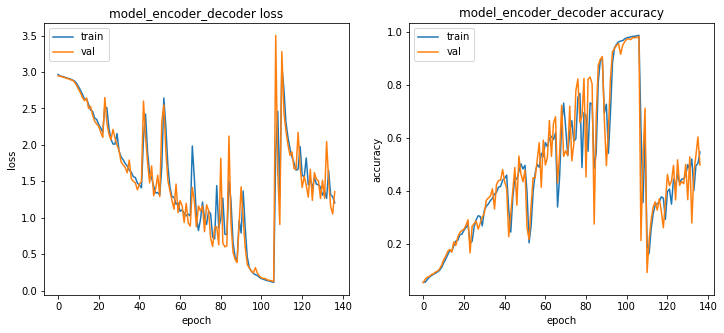

In [ ]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=30)

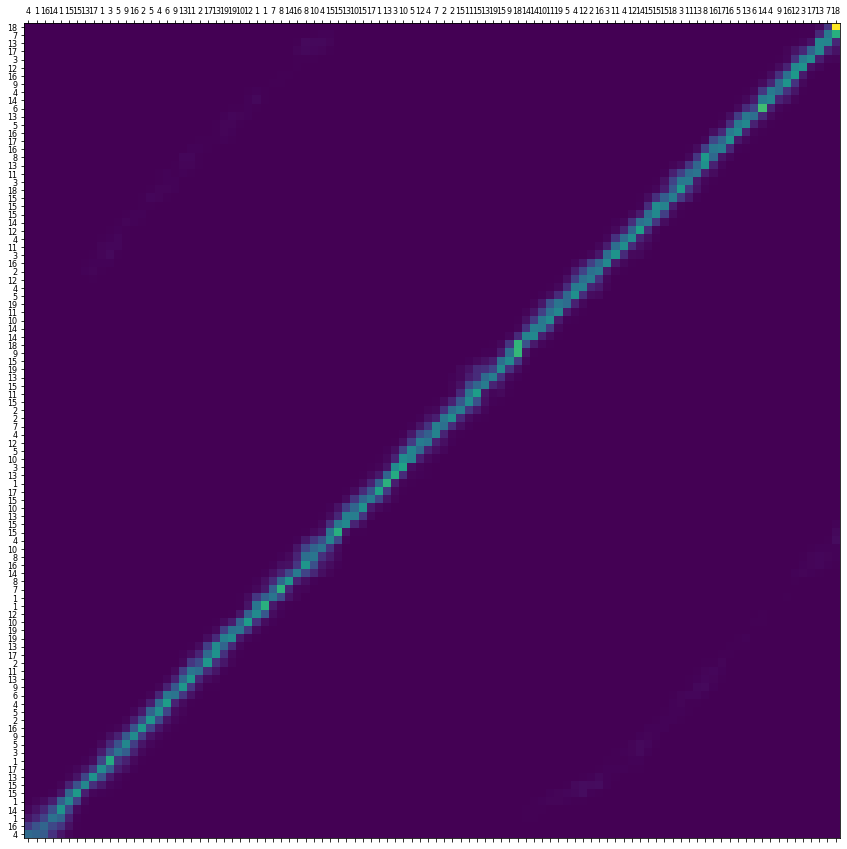

In [ ]:
#Attention weights for Luong dot attention
seq_in = generate_sequence(n_timesteps_in, n_features)
visualization(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)

Let us see the performance using Bahdanau attention.

Epoch 1/200
18/18 [==============================] - 171s 3s/step - loss: 2.9639 - accuracy: 0.0559 - val_loss: 2.9475 - val_accuracy: 0.0534
Epoch 2/200
18/18 [==============================] - 14s 767ms/step - loss: 2.9450 - accuracy: 0.0578 - val_loss: 2.9432 - val_accuracy: 0.0587
Epoch 3/200
18/18 [==============================] - 14s 771ms/step - loss: 2.9417 - accuracy: 0.0630 - val_loss: 2.9389 - val_accuracy: 0.0688
Epoch 4/200
18/18 [==============================] - 14s 773ms/step - loss: 2.9323 - accuracy: 0.0716 - val_loss: 2.9267 - val_accuracy: 0.0762
Epoch 5/200
18/18 [==============================] - 14s 760ms/step - loss: 2.9225 - accuracy: 0.0776 - val_loss: 2.9174 - val_accuracy: 0.0823
Epoch 6/200
18/18 [==============================] - 14s 760ms/step - loss: 2.9135 - accuracy: 0.0828 - val_loss: 2.9093 - val_accuracy: 0.0838
Epoch 7/200
18/18 [==============================] - 14s 766ms/step - loss: 2.9047 - accuracy: 0.0868 - val_loss: 2.8981 - val_accuracy: 0

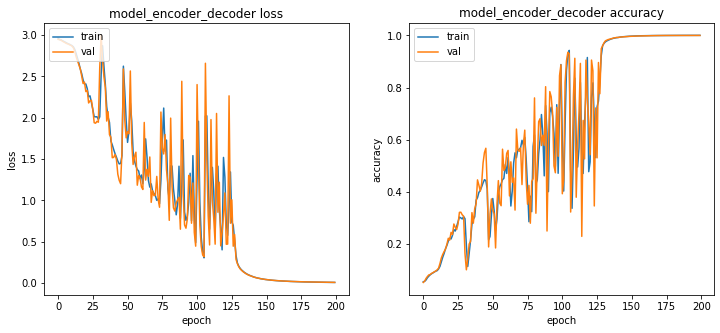

In [ ]:
attention = BahdanauAttention(rnn_units)
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=30)

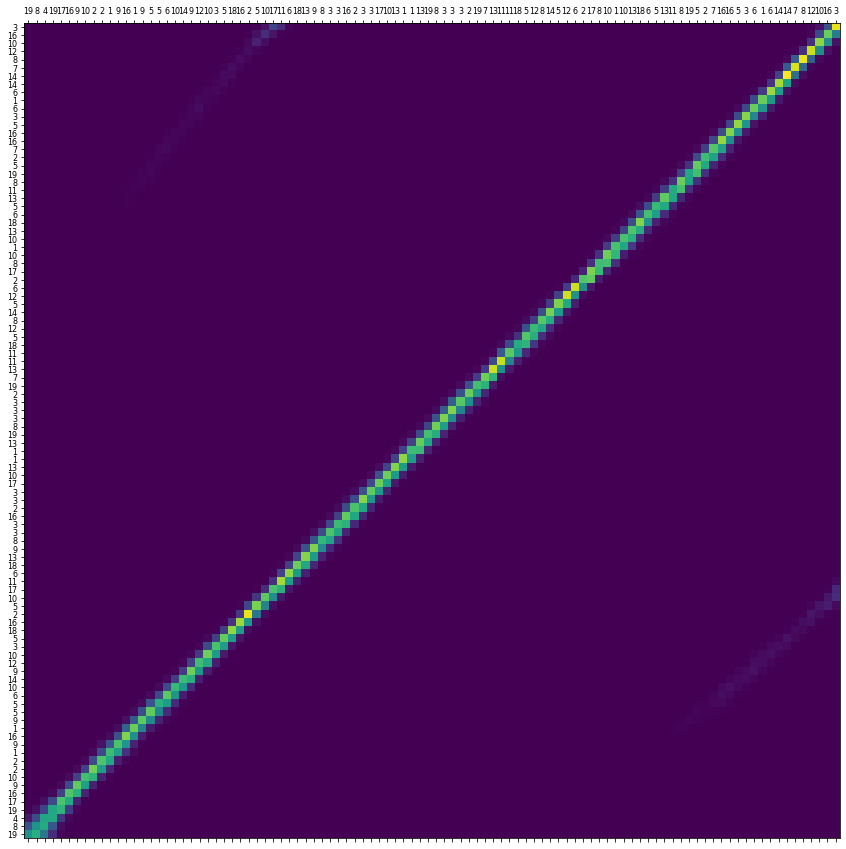

In [ ]:
#Attention weights for Bahdanau attention 
seq_in = generate_sequence(n_timesteps_in, n_features)
visualization(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)

Let us see the performance using Luong general attention.

Epoch 1/200
18/18 [==============================] - 160s 3s/step - loss: 2.9657 - accuracy: 0.0556 - val_loss: 2.9464 - val_accuracy: 0.0530
Epoch 2/200
18/18 [==============================] - 12s 674ms/step - loss: 2.9455 - accuracy: 0.0548 - val_loss: 2.9442 - val_accuracy: 0.0602
Epoch 3/200
18/18 [==============================] - 12s 686ms/step - loss: 2.9419 - accuracy: 0.0620 - val_loss: 2.9404 - val_accuracy: 0.0640
Epoch 4/200
18/18 [==============================] - 12s 694ms/step - loss: 2.9362 - accuracy: 0.0717 - val_loss: 2.9275 - val_accuracy: 0.0795
Epoch 5/200
18/18 [==============================] - 12s 667ms/step - loss: 2.9185 - accuracy: 0.0825 - val_loss: 2.9086 - val_accuracy: 0.0900
Epoch 6/200
18/18 [==============================] - 12s 669ms/step - loss: 2.8935 - accuracy: 0.0939 - val_loss: 2.8800 - val_accuracy: 0.0969
Epoch 7/200
18/18 [==============================] - 12s 662ms/step - loss: 2.8699 - accuracy: 0.1021 - val_loss: 2.8648 - val_accuracy: 0

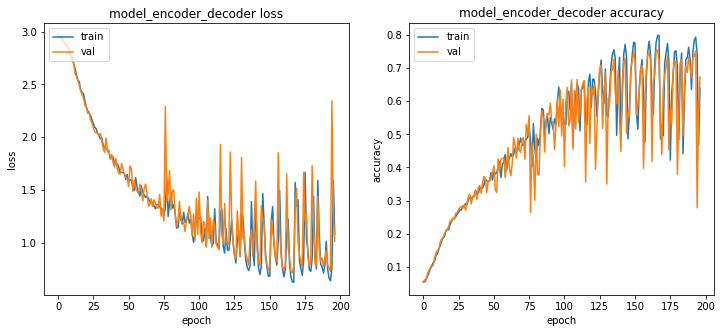

In [ ]:
attention = LuongGeneralAttention(rnn_units)
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=30)

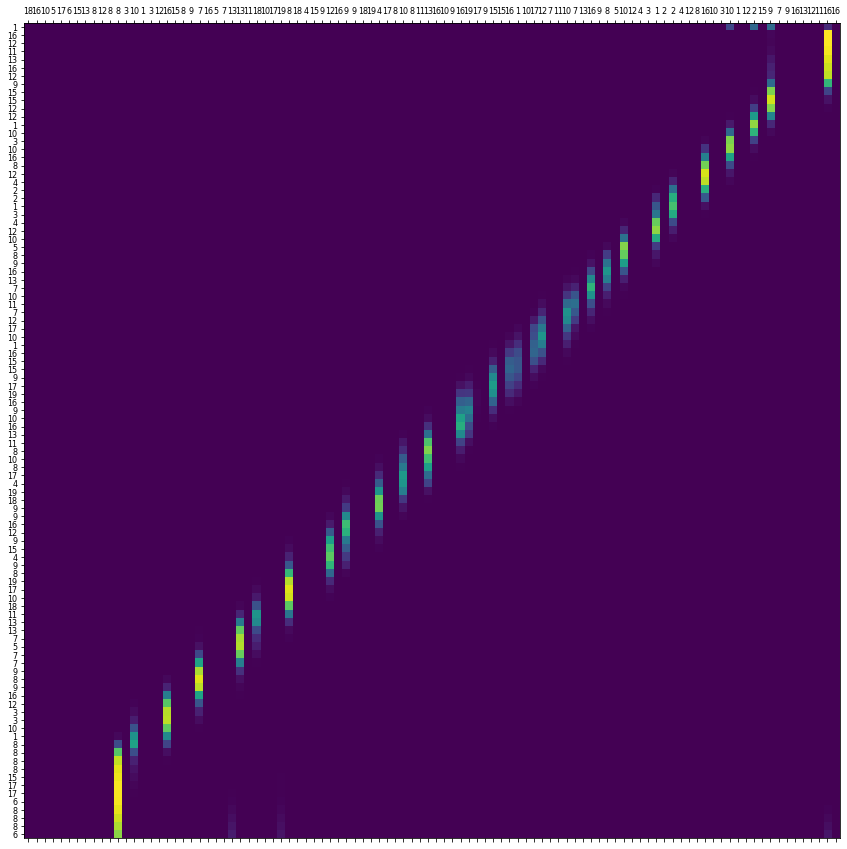

In [ ]:
#Attention weights for Luong general attention 
seq_in = generate_sequence(n_timesteps_in, n_features)
visualization(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)

# Report

+ Bahdanau Attention and Luong General Attention implementation.
+ Comparative.
+ Weight visualization. 
+ Blog site.

The implementation of the Bahdanau Attention and Luong General Attention was quite simple since we have only modificated the ready-made implementation of the Loung dot Attention. The key modifications are:
+ Initialization of some weights, depending on the case, one or two weighted matrices and a hidden layer.
+ Change the attention score to the appropiate one in each case (see the blog site to review the concrete formulas).

Let us compare the methods. Notice that the given example (**Luong Dot Attention**) was not performing very well due to the number of epochs and the patience implemented. Therefore, we incremented the number of epochs up to 200, up to 20 the patience and the performance went up to 98.730% accuracy in training and 97.765% in test. Notice that early stopping ended the program with 137 epochs. We continued with the **Bahdanau Attention**, which, with the same number of epochs and patience, reached 99.984% accuracy in training and 99.955% accuracy in test. Nevertheless, notice that early sttoping was unsuccessful and the 200 epochs were made, but with a really good result. To finish, we implemented **Luong General Attention**, which, with the same number of epochs and patience, did not work as well as the others. The method reached 79.596% accuracy in trianing and 75.860% in test. As in the first case, early stopping ended the program earlier, with 197 epochs, but with a worst performance. It seems that this method needs more epochs and more patience to obtain a better result. We can say that this last method (**Luong General Attention**) is the worst by far.

To finish, let us compare and explain the weights visualizations. First of all, notice that the diagonal obtained is rotated due to the order of the axes. Observe that the first two weighted matrices are really close to a diagonal one (the desire output), while the last one does not (the performance was not as good as the first two!!). 


The blog site:
https://hackmd.io/@davidrosado/Bker7HoDi